In [3]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [4]:
from scipy.optimize import curve_fit

In [5]:
%matplotlib inline

# Resource modeling in CHIME - Part 2 of n
## A prototype stochastic census submodel

In [Part 1](https://github.com/misken/c19/blob/master/mychime/modeling/chime_flow_resources_p1.ipynb) of this CHIME resource modeling series, the goal was to:

> try to help people (including myself) better understand the concepts, math and code behind the resource modeling in [CHIME](https://github.com/CodeForPhilly/chime).

In this notebook I want to explore possibilities for using queueing model based approximations for the census projections in CHIME. My primary reasons are:

* current census model is a deterministic, discrete time, "fluid flow" type model and I wonder about the impact of ignoring stochastic effects in length of stay and in number of admits per day.
* a stochastic model offers the possibility of presenting projected census distribution information for each day instead of one fixed point forecast. It's the tails that can get you.
* I've spent a good part of my career building stochastic models, both queueing based and discrete event simulations, for healthcare systems and I've seen the value they can bring.

**Note:** This notebook was created on 2020-04-05 based on CHIME code as of that date.

## Simulate a base scenario

We'll use the same example from [Part 1](https://github.com/misken/c19/blob/master/mychime/modeling/chime_flow_resources_p1.ipynb). I'll also run the model using the `sim_chime_scenario_runner` wrapper I developed which calls the CHIME model. See Part 1 for details. The important thing is that we'll be working with the exact, unmodified, outputs from the standard CHIME model.

Here are a set of [CHIME input values](https://code-for-philly.gitbook.io/chime/what-is-chime/parameters) for the current model.



    %load tests/dt361.cfg

    --current-hospitalized 802
    --mitigation-date 2020-03-21
    --current-date 2020-03-27
    --doubling-time 3.61
    --hospitalized-day 7
    --hospitalized-rate 0.025
    --icu-days 9
    --icu-rate 0.0075
    --market-share 0.32
    --infectious-days 14
    --n-days 120
    --relative-contact-rate 0.31
    --population 5026226
    --ventilated-day 10
    --ventilated-rate 0.005






Let's run the CHIME model for this scenario.

In [6]:
# Import the scenario runner. It will import various penn_chime artifacts.
import sim_chime_scenario_runner as runner

In [7]:
# This scenario name string will get prepended to all output files
scenario = 'base_dt361'

# Create a penn_chime Parameters object
p = runner.create_params_from_file("tests/dt361.cfg") 

# Run the model
model, results = runner.sim_chime(scenario, p) 

2020-04-06 22:08:05,292 - penn_chime.models - INFO - Using doubling_time: 3.61
2020-04-06 22:08:05,359 - penn_chime.models - INFO - Set i_day = 35
2020-04-06 22:08:05,359 - penn_chime.models - INFO - Estimated date_first_hospitalized: 2020-02-21; current_date: 2020-03-27; i_day: 35
2020-04-06 22:08:05,360 - penn_chime.models - INFO - len(np.arange(-i_day, n_days+1)): 156
2020-04-06 22:08:05,360 - penn_chime.models - INFO - len(raw_df): 156


As a reminder, here are the keys in the `results` dictionary. My `sim_chime_scenario_runner.sim_chime()` function just packages up the various dataframes as well as a few dictionaries of variable values into a container dictionary for output processing convenience.

In [8]:
results.keys()

dict_keys(['scenario', 'input_params_dict', 'intermediate_variables_dict', 'sim_sir_w_date_df', 'dispositions_df', 'admits_df', 'census_df'])

This notebook will mostly be using `admits_df`, `census_df` and the `input_params_dict`. So, let's pull them out into variables to save some typing.

In [9]:
print(results['sim_sir_w_date_df'].iloc[32:37, :])

    day       date   susceptible      infected     recovered
32   -3 2020-03-24  4.961608e+06  45820.673366  18797.631243
33   -2 2020-03-25  4.952772e+06  51383.738170  22070.536484
34   -1 2020-03-26  4.942881e+06  57604.565698  25740.803496
35    0 2020-03-27  4.931814e+06  64556.379610  29855.415331
36    1 2020-03-28  4.919440e+06  72319.383652  34466.585303


In [10]:
admits_df = results['admits_df']
census_df = results['census_df']
inputs = results['input_params_dict']

Let's take a look at each.

In [11]:
admits_df.head(10)

,day,date,hospitalized,icu,ventilated
0,-35,2020-02-21,NaN,NaN,NaN
1,-34,2020-02-22,0.283108,0.084932,0.056622
2,-33,2020-02-23,0.343034,0.102910,0.068607
3,-32,2020-02-24,0.415643,0.124693,0.083129
4,-31,2020-02-25,0.503619,0.151086,0.100724
5,-30,2020-02-26,0.610214,0.183064,0.122043
6,-29,2020-02-27,0.739366,0.221810,0.147873
7,-28,2020-02-28,0.895847,0.268754,0.179169
8,-27,2020-02-29,1.085437,0.325631,0.217087
9,-26,2020-03-01,1.315137,0.394541,0.263027


In [12]:
census_df.head(10)

,day,date,hospitalized,icu,ventilated
0,-35,2020-02-21,NaN,NaN,NaN
1,-34,2020-02-22,0.283108,0.084932,0.056622
2,-33,2020-02-23,0.626142,0.187843,0.125228
3,-32,2020-02-24,1.041785,0.312536,0.208357
4,-31,2020-02-25,1.545405,0.463621,0.309081
5,-30,2020-02-26,2.155619,0.646686,0.431124
6,-29,2020-02-27,2.894984,0.868495,0.578997
7,-28,2020-02-28,3.790831,1.137249,0.758166
8,-27,2020-02-29,4.593160,1.462881,0.975254
9,-26,2020-03-01,5.565264,1.857422,1.238281


In [13]:
inputs

{'current_hospitalized': 802,
 'mitigation_date': datetime.date(2020, 3, 21),
 'current_date': datetime.date(2020, 3, 27),
 'infectious_days': 14,
 'market_share': 0.32,
 'n_days': 120,
 'relative_contact_rate': 0.31,
 'population': 5026226,
 'hospitalized': Disposition(rate=0.025, days=7),
 'icu': Disposition(rate=0.0075, days=9),
 'ventilated': Disposition(rate=0.005, days=10),
 'date_first_hospitalized': datetime.date(2020, 2, 21),
 'doubling_time': 3.61,
 'max_y_axis': None,
 'recovered': 0,
 'region': None,
 'labels': {'hospitalized': 'Hospitalized',
  'icu': 'ICU',
  'ventilated': 'Ventilated',
  'day': 'Day',
  'date': 'Date',
  'susceptible': 'Susceptible',
  'infected': 'Infected',
  'recovered': 'Recovered'},
 'dispositions': {'hospitalized': Disposition(rate=0.025, days=7),
  'icu': Disposition(rate=0.0075, days=9),
  'ventilated': Disposition(rate=0.005, days=10)}}

## Temporal relationship between admits and census

Well known in infinite capacity queueing models with time-dependent Poisson arrivals that census lags behind arrivals (admits). Makes sense. Let's see this.


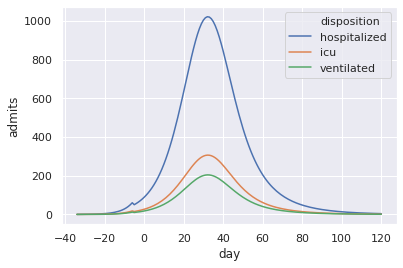

In [14]:
admits_df = results['admits_df']
admits_long = pd.melt(admits_df, 
  id_vars=['day', 'date'],
                       value_vars=['hospitalized', 'icu', 'ventilated'],
                       var_name='disposition', value_name='admits')


sns.lineplot(x='day', y='admits', hue='disposition', 
             data=admits_long);

In [15]:
hosp_admits = admits_df.loc[:, ['day', 'hospitalized']]
hosp_admits.fillna(0, inplace=True)
hosp_admits['rel_day'] = hosp_admits.index.values

hosp_census = census_df.loc[:, ['day', 'hospitalized']]
hosp_census.fillna(0, inplace=True)
hosp_census['rel_day'] = hosp_census.index.values

In [16]:
hosp_admits

,day,hospitalized,rel_day
0,-35,0.000000,0
1,-34,0.283108,1
2,-33,0.343034,2
3,-32,0.415643,3
4,-31,0.503619,4
...,...,...,...
151,116,5.167029,151
152,117,4.869097,152
153,118,4.588644,153
154,119,4.324613,154


In [17]:
hosp_census

,day,hospitalized,rel_day
0,-35,0.000000,0
1,-34,0.283108,1
2,-33,0.626142,2
3,-32,1.041785,3
4,-31,1.545405,4
...,...,...,...
151,116,43.557454,151
152,117,41.035727,152
153,118,38.663053,153
154,119,36.430292,154


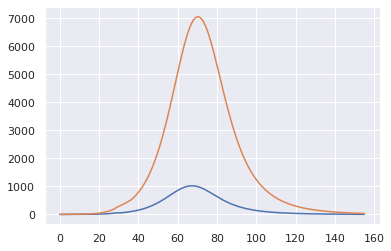

In [18]:
sns.lineplot(data=hosp_admits['hospitalized'])
sns.lineplot(data=hosp_census['hospitalized'])

Let's look more closely at how the peaks relate.

In [19]:
x = np.array(hosp_admits.rel_day)
y_admits = np.array(hosp_admits.hospitalized)
y_census = hosp_census.hospitalized
admit_peak = np.argmax(y_admits)
census_peak = np.argmax(y_census)
lag_txt = "Census lag = {} days".format(census_peak - admit_peak)

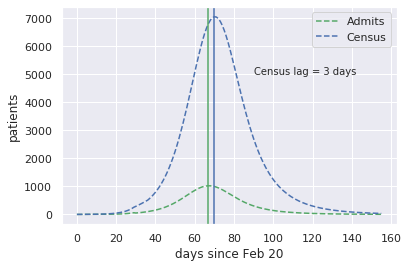

In [20]:
plt.plot(x, y_admits, 'g--', label="Admits")
plt.plot(x, y_census, 'b--', label="Census")
plt.xlabel('days since Feb 20')
plt.ylabel('patients')
plt.axvline(admit_peak, color = 'g')
plt.axvline(census_peak, color = 'b')
plt.text(90,5000, lag_txt)
plt.legend()
plt.show()

Zoom.

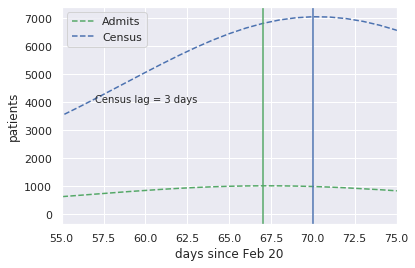

In [21]:
plt.plot(x, y_admits, 'g--', label="Admits")
plt.plot(x, y_census, 'b--', label="Census")
plt.xlabel('days since Feb 20')
plt.ylabel('patients')
plt.xlim(55, 75)
plt.axvline(admit_peak, color = 'g')
plt.axvline(census_peak, color = 'b')
plt.text(57, 4000, lag_txt)
plt.legend()
plt.show()

## Plan of attack for stochastic census model
For $M_t/G/\inf$ queueing models, there are really nice computational formulas for computing the mean value function, $m(t)$, which gives the mean of the Poisson distribution of occupancy at each time $t$. 

In order to use them, we need two things:

* fit some sort of arrival rate function $\lambda(t)$ to the projected admit time series
* decide on length of stay distribution to use for $G$.
* do the above two things wisely so that the math and computing isn't too terrible but is sufficiently accurate in matching mean census.

### Arrival rate plan

From looking at the admit plots above and knowing what we know about SIR models, I'm going to try to fit two logistic functions, one for the growth phase and one for the decay phase. We'll see how they fit together and, if needed, shim them with a quadratic or cubic polynomial. These should be not too bad to work with in the queueing model.

### Service time (LOS) distribution plan

My first thought is to use a hyperexponential distribution with three parallel stages representing three different patient types - patients with no ICU stay, patients who stay in ICU but no vent, and vent patients. The math works out quite nicely for hyperexponential service time (cite the MS paper).

Add citations to work of Eick, Massey and Whitt.

## Fit logistic functions to admits
Piece two logistic together - one that's growth and one that's decay. Then we'll shim them if needed. Start by just exploring a logistic growth model for the first part of the projected admit data.

In [22]:
# Function to fit
def logistic_func(x, a, b, c):
     return a /(1 + b * c ** -x)

Let's just throw some reasonable values in and plot.

In [23]:
(a, b, c) = (1000.0, 100, 1.125)

In [24]:
x = np.array(hosp_admits.rel_day)
y1 = np.array(logistic_func(x, a, b, c))

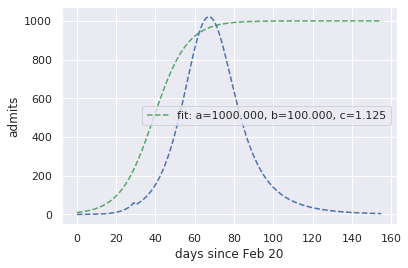

In [25]:
plt.plot(x, y1, 'g--',
         label='fit: a={:5.3f}, b={:5.3f}, c={:5.3f}'.format(a, b, c))
plt.plot(x, y_admits, 'b--')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.legend()
plt.show()

Ok, let's try to find a good fit from time 0 up until the peak.

In [26]:
x_peak = np.argmax(y_admits)
admits_peak = np.max(y_admits)
x_growth = x[:x_peak + 1]
x_decay = x[x_peak + 1:]
y_act_growth = y_admits[:x_peak + 1]
y_act_decay = y_admits[x_peak + 1:]

(a0_growth, b0_growth, c0_growth) = (1000, 1000, 1.1)
# [1.29378304e+03 1.02204732e+03 1.14296202e+00]
(a0_decay, b0_decay, c0_decay) = (1000, 0.001, 0.9)

In [27]:
popt, pcov = curve_fit(logistic_func, x_growth, y_act_growth,  p0=(a0_growth, b0_growth, c0_growth))
print(popt)
y_fit_growth = logistic_func(x_growth, *popt)

[1.26609963e+03 1.60265523e+03 1.14380768e+00]


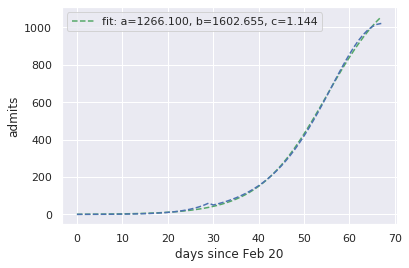

In [28]:
plt.plot(x_growth, y_fit_growth, 'g--',
         label='fit: a={:5.3f}, b={:5.3f}, c={:5.3f}'.format(*popt))
plt.plot(x_growth, y_act_growth, 'b--')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.legend()
plt.show()

Now fit the decay side in a similar way.

In [29]:
popt, pcov = curve_fit(logistic_func, x_decay, y_act_decay,  p0=(a0_decay, b0_decay, c0_decay))
print(popt)
y_fit_decay = logistic_func(x_decay, *popt)

[1.56413231e+03 6.24626446e-04 9.07435017e-01]


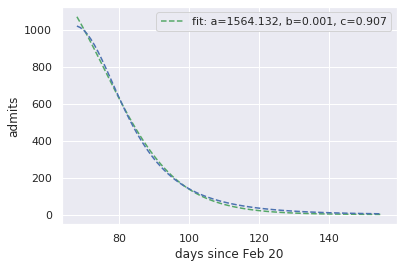

In [30]:
plt.plot(x_decay, y_fit_decay, 'g--',
         label='fit: a={:5.3f}, b={:5.3f}, c={:5.3f}'.format(*popt))
plt.plot(x_decay, y_act_decay, 'b--')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.legend()
plt.show()

Let's join the two pieces together and check the overall fit, especially near the peak where the two logistic functions are duct taped together.

In [31]:
# Join the pieces
y_fit = np.concatenate((y_fit_growth, y_fit_decay), axis=None)
x_fit_peak = np.argmax(y_fit)
admits_fit_peak = np.max(y_fit)

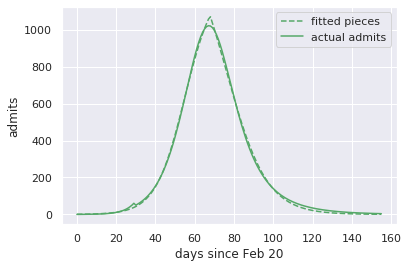

In [32]:
plt.plot(x, y_fit, 'g--',
         label='fitted pieces')
plt.plot(x, y_admits, 'g',
         label='actual admits')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.legend()
plt.show()

Zoom in on the peak.

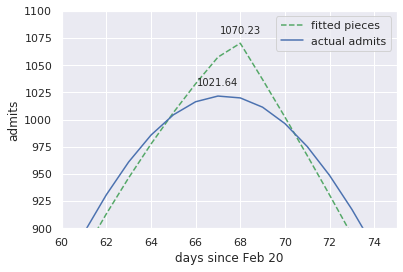

In [33]:
plt.plot(x, y_fit, 'g--',
         label='fitted pieces')
plt.plot(x, y_admits, 'b',
         label='actual admits')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.xlim(60, 75)
plt.ylim(900, 1100)
label_fitted = "{:.2f}".format(admits_fit_peak)
label_admits = "{:.2f}".format(admits_peak)
plt.annotate(label_fitted, # this is the text
                 (x_fit_peak, admits_fit_peak), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.annotate(label_admits, # this is the text
                 (x_peak, admits_peak), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.legend()
plt.show()

Good enough for now. Let's get the queueing part working. Then we can improve this by perhaps using a spline to match the hump between, say, x=62 and x=67. Actually, let's shim them now. Seems fun.

In [34]:
shimx_lower = 65
shimx_upper = 71
x_shim = x[shimx_lower:shimx_upper + 1]
y_shim = y_admits[shimx_lower:shimx_upper + 1]

I'm going to try a quadratic as it looks sufficient to match the hump.

In [35]:
quad_shim = np.polyfit(x_shim, y_shim, 2)

In [36]:
# Function to fit
def quad_func(x, a, b, c):
     return a * x **2 + b * x + c

In [37]:
y_fit_shim = quad_func(x_shim, *quad_shim)
y_fit_shim

array([1004.49448924, 1016.30394435, 1021.42262271, 1019.85052431,
       1011.58764916,  996.63399725,  974.98956859])

In [38]:
y_fit_w_shim = np.concatenate((y_fit_growth[:shimx_lower], y_fit_shim, y_fit_decay[shimx_upper - x_peak:]), axis=None)

In [39]:
# Check for shape consistency (e.g. no off by one errors)
assert y_fit_w_shim.shape == x.shape

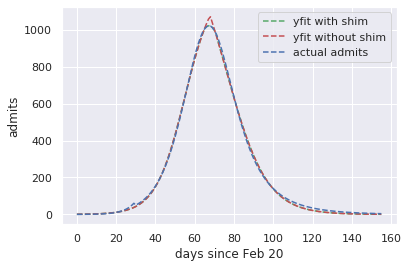

In [40]:
plt.plot(x, y_fit_w_shim, 'g--', label='yfit with shim')
plt.plot(x, y_fit, 'r--', label='yfit without shim')
plt.plot(x, y_admits, 'b--', label='actual admits')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.legend()
plt.show()

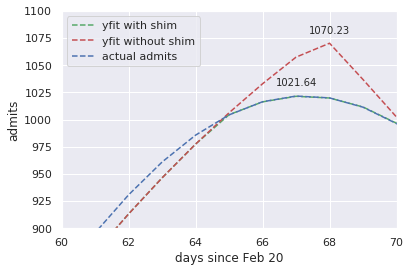

In [41]:
plt.plot(x, y_fit_w_shim, 'g--', label='yfit with shim')
plt.plot(x, y_fit, 'r--', label='yfit without shim')
plt.plot(x, y_admits, 'b--', label='actual admits')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.xlim(60, 70)
plt.ylim(900, 1100)
label_fitted = "{:.2f}".format(admits_fit_peak)
label_admits = "{:.2f}".format(admits_peak)
plt.annotate(label_fitted, # this is the text
                 (x_fit_peak, admits_fit_peak), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.annotate(label_admits, # this is the text
                 (x_peak, admits_peak), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.legend()
plt.show()

Nice.

## Service time distribution parameters
WIP - this is next

    # %load tests/dt361.cfg
    
    --current-hospitalized 802
    --mitigation-date 2020-03-21
    --current-date 2020-03-27
    --doubling-time 3.61
    --hospitalized-day 7
    --hospitalized-rate 0.025
    --icu-days 9
    --icu-rate 0.0075
    --market-share 0.32
    --infectious-days 14
    --n-days 120
    --relative-contact-rate 0.31
    --population 5026226
    --ventilated-day 10
    --ventilated-rate 0.005

In [79]:
vars(p)

{'current_hospitalized': 802,
 'mitigation_date': datetime.date(2020, 3, 21),
 'current_date': datetime.date(2020, 3, 27),
 'infectious_days': 14,
 'market_share': 0.32,
 'n_days': 120,
 'relative_contact_rate': 0.31,
 'population': 5026226,
 'hospitalized': Disposition(rate=0.025, days=7),
 'icu': Disposition(rate=0.0075, days=9),
 'ventilated': Disposition(rate=0.005, days=10),
 'date_first_hospitalized': datetime.date(2020, 2, 21),
 'doubling_time': 3.61,
 'max_y_axis': None,
 'recovered': 0,
 'region': None,
 'labels': {'hospitalized': 'Hospitalized',
  'icu': 'ICU',
  'ventilated': 'Ventilated',
  'day': 'Day',
  'date': 'Date',
  'susceptible': 'Susceptible',
  'infected': 'Infected',
  'recovered': 'Recovered'},
 'dispositions': {'hospitalized': Disposition(rate=0.025, days=7),
  'icu': Disposition(rate=0.0075, days=9),
  'ventilated': Disposition(rate=0.005, days=10)}}

In [80]:
hosp_los = p.hospitalized.days
icu_los = p.icu.days
vent_los = p.ventilated.days
icu_pct = p.icu.rate
vent_pct = p.ventilated.days

Let's start with independent models for hospital beds, ICU beds, and vents.

Now let's pretend there are three simplified patient types.

* Type 1 - just use hospital bed, no icu (and, obviously, no vent)
* Type 2 - just use icu bed but not a vent
* Type 3 - use icu and vent

## M(t)/H3/inf model

WIP - then this

## Stuff from part 1 of the modeling posts
Below is the census related stuff from part 1. We'll likely need some of this to compare queueing model census projections to CHIME census projections.

### Step 3 - Census
Remember, this is a deterministic model. The user is asked to provide three average length of stay (ALOS) values:

* `hospitalized-day` - average time spent in the hospital by **any covid-19 patient, in any bed type**.
* `icu days` - average time spent in an ICU bed **only for those covid-19 patients who went to an ICU**.
* `ventilated-day` - average time spent on a ventilator **only for those covid-19 patients who were ventilated**

**IMPORTANT** - see the Documentation on user inputs for ALOS at https://code-for-philly.gitbook.io/chime/what-is-chime/parameters#length-of-stay.

### Assumptions and interpretations

There are some other important assumptions and interpretations regarding the interplay between these ALOS values for the different resources.

$$
H \subset C \subset V
$$

Ventilated patients are a subset of ICU patients and ICU patients are a subset of hospitalized patients. This keeps things simpler in the sense that we are estimating average census values for each resource independently by, essentially, multiplying the arrival rate (average number of new dispositions per day) by the appropriate ALOS value (the Python code does this in a different manner but the result is the same). A couple of points:

* for those of you with a bit of queueing or "process physics" knowledge, this is just [Little's Law](https://en.wikipedia.org/wiki/Little%27s_law).
* this model is not in any way looking at details of patient flow patterns such as the fact that patients may take different paths through the hospital:
  - Regular bed --> Discharge
  - Regular bed --> ICU --> Regular/step down --> Discharge
  - Regular bed --> ICU --> Discharge
  - ICU --> Discharge
  - ICU --> Regular/step down --> Discharge
  - Step Down --> Discharge
  - ... etc.
* there is no explicit consideration of capacity limits,
* there is no explicit consideration of parameter uncertainty or stochastic processes.

This is **not** a criticism of the model. All models are approximations, models have varying purposes and there are always tradeoffs. The CHIME model balances complexity, number and availability of user inputs, and its goal of being a quick, rough approximation of resource implications during early to middle stages (i.e. before capacity becomes the limiting factor) of a spreading virus. As capacity becomes more of an issue, there will likely be a need for additional models. Discrete event patient flow simulation models are one of the likely candidates. If interested, you can see simple examples of such models using the Python [simpy](https://simpy.readthedocs.io/en/latest/) package in two blog posts I did, [here](http://hselab.org/simpy-getting-started-patient-flow-modeling.html) and [here](http://hselab.org/simpy-first-oo-patflow-model.html).

### Computing average census values
Census can be computed for each resource independently using the `admits_df` DataFrame and the appropriate ALOS value for the resource. Here's the annotated code.

```python
def build_census_df(
    admits_df: pd.DataFrame,
    lengths_of_stay: Dict[str, int],
) -> pd.DataFrame:
    """Average Length of Stay for each disposition of COVID-19 case (total guesses)"""
    return pd.DataFrame({
        'day': admits_df.day,
        'date': admits_df.date,
        **{
            key: (                       # See below for illustration of this computation
                admits_df[key].cumsum()
                - admits_df[key].cumsum().shift(los).fillna(0)
            )
            for key, los in lengths_of_stay.items()
        }
    })
```

Ok, the key line is

```python
admits_df[key].cumsum()
                - admits_df[key].cumsum().shift(los).fillna(0)
```

Let's see how this works.

In [12]:
# Grab the dataframes we need
admits_df = results['admits_df']
census_df = results['census_df']

# Let's look at hospitalized 
key = 'hospitalized'
los = 7

# Make a mini DataFrame with columns to illustrate the computation
admits = admits_df[key]
census = census_df[key]
cum_admits = admits_df[key].cumsum()
shifted_cum_admits = admits_df[key].cumsum().shift(los).fillna(0)

census_demo_df = pd.DataFrame({
    'admits': admits,
    'cum_admits': cum_admits,
    'shifted_cum_admits': shifted_cum_admits,
    'census_computation': cum_admits - shifted_cum_admits,
    'census_chime': census
})

census_demo_df.head(15)

,admits,cum_admits,shifted_cum_admits,census_computation,census_chime
0,NaN,NaN,0.000000,NaN,NaN
1,0.283108,0.283108,0.000000,0.283108,0.283108
2,0.343034,0.626142,0.000000,0.626142,0.626142
3,0.415643,1.041785,0.000000,1.041785,1.041785
4,0.503619,1.545405,0.000000,1.545405,1.545405
5,0.610214,2.155619,0.000000,2.155619,2.155619
6,0.739366,2.894984,0.000000,2.894984,2.894984
7,0.895847,3.790831,0.000000,3.790831,3.790831
8,1.085437,4.876268,0.283108,4.593160,4.593160
9,1.315137,6.191406,0.626142,5.565264,5.565264


Consider day 9. The ALOS is 7 days. So, which admits contribute to census on day 9? Well it's the admits from day 3-9, inclusive (7 days worth). All that the code is doing is summing up all the admits from day 0-9, the `cumsum`, and then subtracting off those from 0-2, the shifted `cumsum`. Doing this prevents us from having to do "index math".

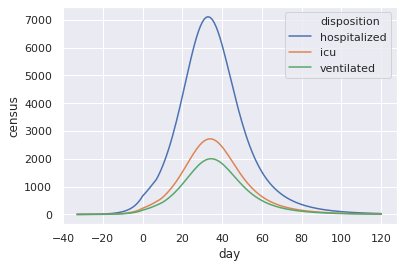

In [47]:
census_df = results['census_df']
census_long = pd.melt(census_df, 
  id_vars=['day', 'date'],
                       value_vars=['hospitalized', 'icu', 'ventilated'],
                       var_name='disposition', value_name='census')


sns.lineplot(x='day', y='census', hue='disposition', 
             data=census_long);

## Sinusoidal arrival rates (not a good fit)

In [60]:
# Compute average arrival rate
lambda_bar = hosp_admits['hospitalized'].mean()
lambda_bar

239.3990216771688

In [109]:
psi_cycle_len_guess = 200
gamma_freq_guess = 2 * math.pi / psi_cycle_len_guess
gamma_freq_guess

0.031415926535897934

In [110]:
# Relative 
alpha_rel_amp_guess = 4

In [111]:
beta_guess = lambda_bar * alpha_rel_amp_guess
beta_guess

957.5960867086752

In [112]:
sin_guess = lambda_bar + beta_guess * np.sin(gamma_freq_guess * hosp_admits.rel_day)
sin_guess

0      239.399022
1      269.477842
2      299.526977
3      329.516774
4      359.417636
          ...    
150   -718.197065
151   -717.724549
152   -716.307468
153   -713.947220
154   -710.646134
Name: rel_day, Length: 155, dtype: float64

In [113]:
x = np.array(hosp_admits.rel_day)
y = np.array(sin_guess)
y_act = hosp_admits['hospitalized']

2020-04-05 10:11:23,960 - matplotlib.legend - WARNING - No handles with labels found to put in legend.


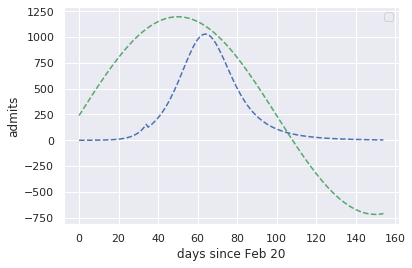

In [114]:
plt.plot(x, y, 'g--')
plt.plot(x, y_act, 'b--')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.legend()
plt.show()

In [115]:
# Function to fit
def sin_func(x, a, b, c):
     return a + b * np.sin(c * x)

In [116]:
popt, pcov = curve_fit(sin_func, x, y_act,  p0=(240, 950, 0.03))
print(popt)

[-8.24497333e+01  5.91986511e+02  2.28486209e-02]


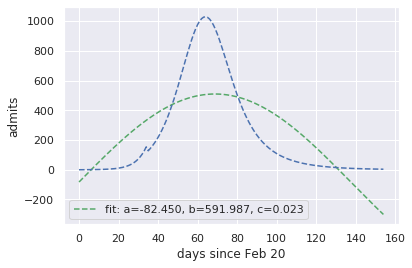

In [117]:
plt.plot(x, func(x, *popt), 'g--',
         label='fit: a={:5.3f}, b={:5.3f}, c={:5.3f}'.format(*popt))
plt.plot(x, y_act, 'b--')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.legend()
plt.show()

## Concluding remarks
Hopefully this helps clarify how CHIME is currently computing resource use. In the next notebook, I'll build on this and explore the implied arrival rates and ALOS values for subpopulations of patients such as those covid-19 patients who do NOT use ICU and those ICU patients who do NOT use a vent. These are simple algebraic computations and by feeding them back to users, might help people calibrate their inputs better.

<font size="2">This material is made available under the [MIT License](https://opensource.org/licenses/MIT).</font>